# Medical Image Segmentation with UNet++ and Datamint

This notebook demonstrates how to build an end-to-end **semantic segmentation** pipeline using **Datamint** and the **BUSI** (Breast Ultrasound Images) dataset with a **UNet++** architecture.

## Overview

You will learn how to:
- **Set up a Datamint project** for managing medical imaging data
- **Upload ultrasound images and segmentation masks** to Datamint
- **Build a custom PyTorch Dataset** that integrates with Datamint
- **Implement UNet++ with combined loss functions** (CrossEntropy + Dice)
- **Train the model** using PyTorch Lightning with MLflow tracking
- **Deploy the model** for inference using Datamint's model serving

## Table of Contents

1. [Setup: Create Project and Initialize API](#1-setup-create-project-and-initialize-api)
2. [Dataset Preparation: Download and Upload BUSI](#2-dataset-preparation-download-and-upload-busi)
3. [Custom PyTorch Dataset](#3-custom-pytorch-dataset)
4. [Model Architecture: UNet++ with Combined Loss](#4-model-architecture-unet-with-combined-loss)
5. [Training with MLflow Integration](#5-training-with-mlflow-integration)
6. [Visualization and Evaluation](#6-visualization-and-evaluation)
7. [Model Deployment](#7-model-deployment)

## Required Dependencies

```bash
pip install datamint segmentation-models-pytorch albumentations
```

## Dataset Overview

The **BUSI** (Breast Ultrasound Images) dataset contains ultrasound images of breast cancer with corresponding segmentation masks.
Three classes: benign, malignant, and normal tissues.

Dataset reference:
> Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

In [1]:
from datamint import Api
from datamint.mlflow import set_project

PROJECT_NAME = "UNetPP_Segmentation_Tutorial"
api = Api()

## 1. Setup: Create Project and Initialize API

In this section, we will:
- Create a new Datamint project (or retrieve an existing one)
- Set up the MLflow project context for experiment tracking

In [2]:
proj = api.projects.get_by_name(PROJECT_NAME)
if proj is None:
    print(f"Creating project '{PROJECT_NAME}'")
    proj = api.projects.create(
        name=PROJECT_NAME,
        description="Tutorial project for UNet++ segmentation on BUSI dataset"
    )
else:
    print(f"Using existing project '{PROJECT_NAME}'")

set_project(PROJECT_NAME)  # Important for proper experiment tracking

Using existing project 'UNetPP_Segmentation_Tutorial'


Project(id='6c770f6c-6483-4af3-924c-16b122bfc6d5', name='UNetPP_Segmentation_Tutorial', created_at='2025-12-23T14:33:11.807Z', created_by='datamint-dev@mail.com', dataset_id='d8c94f56-0897-428b-8d5a-7b846233522a', worklist_id='9ad15be0-4c6d-4537-ab8b-6464fab5eae4', archived=False, resource_count=780, annotated_resource_count=0, description='Tutorial project for UNet++ segmentation on BTCV dataset', viewable_ai_segs=None, editable_ai_segs=None, closed_resources_count=0, resources_to_annotate_count=0, most_recent_experiment=None, annotators=[{'email': 'datamint-dev@mail.com', 'roles': ['PROJECT_OWNER'], 'status': 'active'}])

## 2. Dataset Preparation: Download and Upload BUSI

In this section, we will:
- Download the BUSI dataset
- Upload ultrasound images to Datamint
- Upload corresponding segmentation masks
- Create train/val/test splits

### 2.1 Download BUSI Dataset

The BUSI dataset is available from Kaggle. For this tutorial, we'll use the breast ultrasound images dataset.

> Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

In [3]:
import os
import requests
import zipfile
from pathlib import Path

BUSI_URL = "https://www.kaggle.com/api/v1/datasets/download/sabahesaraki/breast-ultrasound-images-dataset"
DATA_DIR = Path("/tmp/BUSI_dataset") # Change this path as needed

if not DATA_DIR.exists():
    print("Downloading BUSI dataset...")

    # Download the dataset
    response = requests.get(BUSI_URL, stream=True)
    response.raise_for_status()
    zip_path = DATA_DIR / "Dataset_BUSI.zip"

    DATA_DIR.mkdir(parents=True, exist_ok=True)
    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    os.remove(zip_path)
    print("Download complete!")
else:
    print(f"Dataset already exists at {DATA_DIR}")

Dataset already exists at /tmp/BUSI_dataset


### 2.2 Explore Dataset Structure

The BUSI dataset contains folders for each class:
- **benign**: Images and masks for benign cases
- **malignant**: Images and masks for malignant cases
- **normal**: Images and masks for normal cases

```
Dataset_BUSI/
├── benign/
│   ├── benign (1).png
│   ├── benign (1)_mask.png
│   └── ...
├── malignant/
│   └── ...
└── normal/
    └── ...
```

In [4]:
# Find image and label paths
base_dir = DATA_DIR / "Dataset_BUSI_with_GT"
classes = ["benign", "malignant", "normal"]

image_paths = []
label_paths = []

for cls in classes:
    cls_dir = base_dir / cls
    # Images are files that don't contain "_mask"
    cls_images = sorted([p for p in cls_dir.glob("*.png") if "_mask" not in p.name])
    for img_p in cls_images:
        # Find corresponding mask (taking the first one if multiple exist)
        mask_p = cls_dir / f"{img_p.stem}_mask.png"
        if mask_p.exists():
            image_paths.append(img_p)
            label_paths.append(mask_p)

print(f"Found {len(image_paths)} ultrasound images")
print(f"Found {len(label_paths)} segmentation masks")

Found 780 ultrasound images
Found 780 segmentation masks


### 2.3 Define Classes

We map the folder names to class indices.

In [ ]:
# 0: Background, 1: Benign, 2: Malignant
# Normal images are treated as background (class 0)
NUM_CLASSES = 3 

### 2.4 Upload Images to Datamint

We upload each ultrasound image as a resource with appropriate tags.

In [6]:
# Upload images to Datamint
uploaded_resources = api.resources.upload_resources(
    [str(p) for p in image_paths],
    tags=['busi', 'ultrasound', 'breast'],
    publish_to=proj,
    progress_bar=True
)

print(f"Uploaded {len(uploaded_resources)} images to Datamint")

Uploading resources:   0%|          | 0/780 [00:00<?, ?file/s]

Uploaded 780 images to Datamint


### 2.5 Upload Segmentation Masks

Now we upload the corresponding segmentation masks.

In [ ]:
from tqdm.auto import tqdm

# Get resources from project
all_resources = list(api.resources.get_list(project_name=PROJECT_NAME, tags=['busi']))
filename_to_resource = {r.filename: r for r in all_resources}

# Upload segmentation masks
for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
    if 'normal' in img_path.parent.name:
        # Skip normal images (no lesions)
        continue
    resource = filename_to_resource[img_path.name]
    
    # Determine class from file path. Example ``img_path``: 'Dataset_BUSI_with_GT/benign/BUSI_123.png'
    cls_name = img_path.parent.name # 'benign' or 'malignant'
    
    api.annotations.upload_segmentations(
        resource=resource,
        file_path=label_path,
        name=cls_name,
        imported_from="Original GT BUSI Dataset", # source of the masks. Arbitrary string
    )

print("Segmentation masks uploaded successfully!")

  0%|          | 0/780 [00:00<?, ?it/s]

Segmentation masks uploaded successfully!


In [114]:
# Verify uploads - inspect a sample resource
sample_resource = api.resources.get_list(project_name=PROJECT_NAME, limit=1)[0]
sample_annotations = api.annotations.get_list(resource=sample_resource, annotation_type='segmentation')

print(f"Resource: {sample_resource.filename}")
print(f"  Number of segmentation annotations: {len(sample_annotations)}")
if sample_annotations:
    print(f"  First annotation: {sample_annotations[0].asdict()}")

Resource: normal (95).png
  Number of segmentation annotations: 0


### 2.6 Create Train/Validation/Test Splits

We split the dataset into three subsets using tags for reproducibility.

| Split | Percentage | Purpose |
|-------|------------|---------|
| Train | 70% | Model training |
| Validation | 15% | Hyperparameter tuning, early stopping |
| Test | 15% | Final model evaluation |

In [38]:
import random

# Get all resources
all_resources = list(api.resources.get_list(project_name=PROJECT_NAME, tags=['busi']))
all_resources.sort(key=lambda r: r.filename)

# Shuffle with fixed seed
random.seed(42)
random.shuffle(all_resources)

# Split ratios
n_total = len(all_resources)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_resources = all_resources[:n_train]
val_resources = all_resources[n_train:n_train + n_val]
test_resources = all_resources[n_train + n_val:]

print(f"Total resources: {n_total}")
print(f"Training: {len(train_resources)}")
print(f"Validation: {len(val_resources)}")
print(f"Test: {len(test_resources)}")

Total resources: 780
Training: 546
Validation: 117
Test: 117


In [ ]:
# Apply split tags to resources
api.resources.add_tags(train_resources, ['split:train'])
api.resources.add_tags(val_resources, ['split:val'])
api.resources.add_tags(test_resources, ['split:test'])

## 3. Custom PyTorch Dataset

In this section, we'll build a PyTorch Dataset that:
- Fetches images and segmentation masks from Datamint
- Applies normalization
- Uses Albumentations for data augmentation

### 3.1 Define Data Transforms

We use [Albumentations](https://albumentations.ai/) for image and mask augmentation. The key is that augmentations are applied **consistently** to both image and mask.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Image size for UNet++ (should be divisible by 32 for encoder-decoder architectures)
IMAGE_SIZE = 256

# Training transforms with augmentation
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(0,1),  # Normalize to [0, 1] by dividing by 255
    ToTensorV2(),
])

# Validation/Test transforms (no augmentation)
val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(0,1), # Normalize to [0, 1] by dividing by 255
    ToTensorV2(),
])

### 3.2 Implement Custom PyTorch Dataset

The `MedicalSegmentationDataset` class handles:
- Loading images from Datamint
- Applying preprocessing and augmentation
- Returning image-mask pairs for training

In [ ]:
import torch
from torch.utils.data import Dataset
from collections import defaultdict
import cv2
import numpy as np

class MedicalSegmentationDataset(Dataset):
    def __init__(
        self,
        split: str | None = None,
        transforms=None,
    ):
        self.transforms = transforms
        self.num_classes = NUM_CLASSES
        
        self.resources = list(api.resources.get_list(
            project_name=PROJECT_NAME,
            tags=[f'split:{split}'] if split else None,
        ))
        
        all_annotations = api.annotations.get_list(
            resource=self.resources,
            annotation_type='segmentation'
        )
        
        self.resource_annotations = defaultdict(list) # just mapping resource_id -> [annotations]
        for ann in all_annotations:
            self.resource_annotations[ann.resource_id].append(ann)
        
    def __len__(self):
        return len(self.resources)
    
    def __getitem__(self, idx) -> dict:
        resource = self.resources[idx]
        
        # Load image
        image = resource.fetch_file_data(auto_convert=True, use_cache=True)
        # image is a PIL.Image object
        image = np.array(image) # image.shape: (H, W, 3)
        # Convert to grayscale if RGB: (H, W, 3) -> (H, W)
        if image.ndim == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # image = normalize_image(image)
        
        # Load mask
        annotations = self.resource_annotations[resource.id]
        if not annotations:
            mask = np.zeros_like(image, dtype=np.int64)
        else:
            if len(annotations) > 1:
                print(f"Warning: Resource {resource.filename} has multiple annotations. Using the first one.")
            mask = np.array(annotations[0].fetch_file_data(use_cache=True)).astype(np.int64)
        
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).long()
        mask = mask // 255  # Convert mask pixel values from {0,255} to {0,1}. Specific of this dataset

        # Convert it back to RGB by repeating channels if needed
        image = image.repeat(3, 1, 1)

        # final shapes: image: (3, H, W), mask: (H, W)
        
        return {"image": image, "mask": mask, "filename": resource.filename}

In [117]:
# Test Dataset

train_dataset = MedicalSegmentationDataset(
    split='train',
    transforms=train_transforms
)

train_dataset[0].keys()  # Fetch first sample to test

dict_keys(['image', 'mask', 'filename'])

### 3.4 Create DataLoaders

Now we instantiate datasets and dataloaders for each split.

In [47]:
from torch.utils.data import DataLoader

# Configuration
BATCH_SIZE = 16 # Adjust based on your GPU memory
NUM_WORKERS = 4  # Adjust based on your CPU cores


# Create datasets
print("Building training dataset...")
train_dataset = MedicalSegmentationDataset(
    split='train',
    transforms=train_transforms,
)
print(f"  Training samples (slices): {len(train_dataset)}")

print("Building validation dataset...")
val_dataset = MedicalSegmentationDataset(
    split='val',
    transforms=val_transforms,
)
print(f"  Validation samples (slices): {len(val_dataset)}")

print("Building test dataset...")
test_dataset = MedicalSegmentationDataset(
    split='test',
    transforms=val_transforms,
)
print(f"  Test samples (slices): {len(test_dataset)}")

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

Building training dataset...
  Training samples (slices): 546
Building validation dataset...
  Validation samples (slices): 117
Building test dataset...
  Test samples (slices): 117


Batch image shape: torch.Size([16, 3, 256, 256])
Batch mask shape: torch.Size([16, 256, 256])
Filename: benign (265).png
Filename: benign (98).png


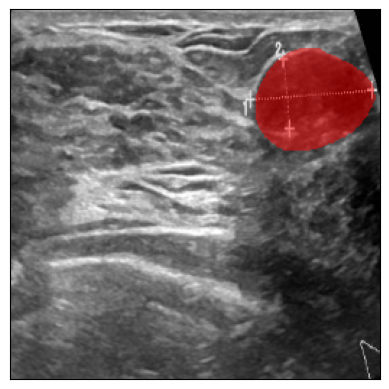

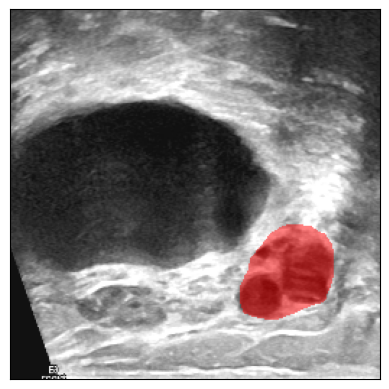

In [48]:
# Visualize a sample batch
from datamint.utils.visualization import show, draw_masks


sample_batch = next(iter(train_dataloader))
print(f"Batch image shape: {sample_batch['image'].shape}")  # (B, C, H, W)
print(f"Batch mask shape: {sample_batch['mask'].shape}")    # (B, H, W)

# Plot first 2 samples
for i in range(2):
    img = sample_batch['image'][i]
    mask = sample_batch['mask'][i]
    print(f"Filename: {sample_batch['filename'][i]}")
    img_with_mask = draw_masks(img, mask)
    show(img_with_mask)

## 4. Model Architecture: UNet++ with Combined Loss

In this section, we'll implement:
- **UNet++** architecture using `segmentation_models_pytorch`
- **Dice Loss** for handling class imbalance
- **Combined Loss** (CrossEntropy + Dice) for better segmentation
- **Lightning Module** for training

### 4.1 UNet++ Architecture

UNet++ is an improved version of U-Net with nested dense skip connections. This architecture enhances feature propagation and reduces the semantic gap between the encoder and decoder.

### 4.2 Custom Loss Functions

For semantic segmentation, we use a combination of:
- **CrossEntropyLoss**: Standard classification loss per pixel
- **Dice Loss**: Optimizes the Dice coefficient directly, handles class imbalance better

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DiceLoss(nn.Module):
    """Dice Loss for multi-class segmentation.
    
    Dice Loss = 1 - Dice Coefficient
    
    The Dice coefficient measures overlap between predicted and ground truth masks.
    It's particularly effective for imbalanced datasets where background dominates.
    """
    
    def __init__(self, smooth: float = 1e-6, ignore_index: int = -100):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: Predictions (B, C, H, W) - logits
            target: Ground truth (B, H, W) - class indices
            
        Returns:
            Dice loss (scalar)
        """
        num_classes = pred.shape[1]
        
        # Convert logits to probabilities
        pred_soft = F.softmax(pred, dim=1)
        
        # One-hot encode target
        target_one_hot = F.one_hot(target.long(), num_classes)  # (B, H, W, C)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)
        
        # Calculate Dice per class
        dims = (0, 2, 3)  # Batch, Height, Width
        intersection = torch.sum(pred_soft * target_one_hot, dim=dims)
        union = torch.sum(pred_soft, dim=dims) + torch.sum(target_one_hot, dim=dims)
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        # Average over classes (excluding background optionally)
        return 1.0 - dice.mean()


class CombinedLoss(nn.Module):
    """Combined CrossEntropy and Dice Loss.
    
    This combination provides:
    - CrossEntropy: Pixel-level classification accuracy
    - Dice: Global overlap optimization, handles class imbalance
    
    Args:
        num_classes: Number of segmentation classes
        ce_weight: Weight for CrossEntropy loss
        dice_weight: Weight for Dice loss
    """
    
    def __init__(
        self,
        num_classes: int,
        ce_weight: float = 1.0,
        dice_weight: float = 1.0,
        class_weights: torch.Tensor | None = None,
    ):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.dice_loss = DiceLoss()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: Predictions (B, C, H, W) - logits
            target: Ground truth (B, H, W) - class indices
            
        Returns:
            Combined loss (scalar)
        """
        ce = self.ce_loss(pred, target.long())
        dice = self.dice_loss(pred, target)
        
        return self.ce_weight * ce + self.dice_weight * dice


# Quick test
dummy_pred = torch.randn(2, NUM_CLASSES, 64, 64)
dummy_target = torch.randint(0, NUM_CLASSES, (2, 64, 64))

loss_fn = CombinedLoss(num_classes=NUM_CLASSES)
loss = loss_fn(dummy_pred, dummy_target)
print(f"Test loss value: {loss.item():.4f}")

Test loss value: 2.4755


### 4.3 UNet++ Lightning Module

We wrap UNet++ in a PyTorch Lightning module for clean training code.

In [63]:
import segmentation_models_pytorch as smp
import lightning as L
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore


class UNetPPModule(L.LightningModule):
    """PyTorch Lightning module for UNet++ segmentation.
    
    This module handles:
    - Model architecture (UNet++ with pretrained encoder)
    - Combined loss function (CrossEntropy + Dice)
    - Metrics tracking (IoU, Dice)
    - Optimizer configuration with learning rate scheduling
    
    Args:
        num_classes: Number of segmentation classes (including background)
        encoder_name: Name of the encoder backbone (e.g., 'resnet34', 'efficientnet-b0')
        learning_rate: Initial learning rate
    """
    
    def __init__(
        self,
        num_classes: int = 4,
        encoder_name: str = 'resnet34',
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.save_hyperparameters() # Save hyperparameters for logging

        self.learning_rate = learning_rate
        
        # UNet++ model from segmentation_models_pytorch
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=3,  # RGB input (we repeat grayscale to 3 channels)
            classes=num_classes,
        )
        
        # Loss function
        self.criterion = CombinedLoss(
            num_classes=num_classes,
            ce_weight=1.0,
            dice_weight=1.0,
        )

        # Metrics for each split
        # Note: MeanIoU expects predictions and targets as class indices
        self.iou_metrics = {
            'train': MeanIoU(num_classes=num_classes, per_class=False),
            'val': MeanIoU(num_classes=num_classes, per_class=False),
            'test': MeanIoU(num_classes=num_classes, per_class=False),
        }
        # register the iou metrics:
        for stage, metric in self.iou_metrics.items():
            self.add_module(f"{stage}_mean_iou", metric)

        self.dice_metrics = {
            'train': GeneralizedDiceScore(num_classes=num_classes),
            'val': GeneralizedDiceScore(num_classes=num_classes),
            'test': GeneralizedDiceScore(num_classes=num_classes),
        }
        # register the dice metrics:
        for stage, metric in self.dice_metrics.items():
            self.add_module(f"{stage}_dice_score", metric)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through UNet++."""
        return self.model(x)
    
    def _common_step(self, batch: dict, stage: str) -> torch.Tensor:
        """Common step for train/val/test.
        
        Args:
            batch: Dictionary with 'image' and 'mask' tensors
            stage: One of 'train', 'val', 'test'
            
        Returns:
            Loss tensor
        """
        images = batch['image']
        masks = batch['mask']
        
        # Forward pass
        logits = self(images)  # (B, C, H, W)
        
        # Compute loss
        loss = self.criterion(logits, masks)
        
        # Get predictions (class indices)
        preds = torch.argmax(logits, dim=1)  # (B, H, W)
        
        # Update metrics
        if stage is not None:
            self.iou_metrics[stage].update(preds, masks)
            self.dice_metrics[stage].update(preds, masks)
            self.log(f'{stage}/loss', loss, on_step=(stage == 'train'), on_epoch=True, prog_bar=True, batch_size=len(images))
        
        return loss
    
    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'train')
    
    def validation_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'val')
    
    def test_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'test')
    
    def predict_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        images = batch['image']
        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        return preds
    
    def _common_epoch_end(self, stage: str):
        iou = self.iou_metrics[stage]
        dice = self.dice_metrics[stage]
        self.log(f'{stage}/iou', iou.compute(), prog_bar=True)
        self.log(f'{stage}/dice', dice.compute())
        iou.reset()
        dice.reset()
    
    def on_train_epoch_end(self):
        self._common_epoch_end('train')
    
    def on_validation_epoch_end(self):
        self._common_epoch_end('val')

    def on_test_epoch_end(self):
        self._common_epoch_end('test')
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4,
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/loss',
                'interval': 'epoch',
            }
        }

In [55]:
# Instantiate the model
model = UNetPPModule(
    num_classes=NUM_CLASSES,
    encoder_name='resnet34',  # Lightweight encoder for faster training
    learning_rate=1e-4,
)

# Test forward pass
with torch.no_grad():
    sample_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    sample_output = model(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")

    # test loss computation
    sample_target = train_dataloader.dataset[-1]['mask']  # (1, H, W)
    sample_loss = model.criterion(sample_output, sample_target.unsqueeze(0))
    print(f"Sample loss: {sample_loss.item():.4f}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 4, 256, 256])
Sample loss: 2.3505


## 5. Training with MLflow Integration

In this section, we'll:
- Configure MLflow for experiment tracking
- Set up model checkpointing with automatic registration
- Train the model with early stopping
- Monitor progress via Datamint dashboard

In [56]:
from datamint.mlflow.lightning.callbacks import MLFlowModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import EarlyStopping

# Ensure project context is set
set_project(PROJECT_NAME)

# MLflow checkpoint callback
# This callback automatically:
# - Saves the best model based on validation IoU
# - Registers the model in MLflow Model Registry after testing
checkpoint_callback = MLFlowModelCheckpoint(
    monitor="val/iou",                    # Metric to monitor
    mode="max",                           # Save when metric increases
    save_top_k=1,                         # Keep only the best model
    filename="best_unetpp",               # Checkpoint filename
    save_weights_only=True,              # Save full model state
    register_model_name=PROJECT_NAME,     # Name in Model Registry
    register_model_on='test',             # Register after test evaluation
)

# Early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val/iou",
    mode="max",
    patience=10                          # Stop if no improvement for 10 epochs
)

# MLflow logger for experiment tracking
mlflow_logger = MLFlowLogger(
    experiment_name=f"{PROJECT_NAME}_training",
    run_name="unetpp_resnet34_busi",
)

print("Training callbacks configured!")

Training callbacks configured!


### 5.1 Start Training

We use PyTorch Lightning's Trainer for clean, scalable training.

In [57]:
# Initialize trainer
trainer = L.Trainer(
    max_epochs=50,                        # Maximum training epochs
    logger=mlflow_logger,                 # MLflow logging
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='auto',                   # Auto-detect GPU/CPU
    devices=1,                            # Single device
    precision='16-mixed',                 # Mixed precision for faster training
    log_every_n_steps=10,                 # Log frequency
    num_sanity_val_steps=2,               # Validation sanity check
)

# Start training
print("🚀 Starting training...")
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

[12/24/25 10:57:06] INFO     Using 16bit Automatic Mixed Precision (AMP)               ]8;id=682054;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py\accelerator_connector.py]8;;\:]8;id=283201;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py#515\515]8;;\

                    INFO     GPU available: True (cuda), used: True                                    ]8;id=487455;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=456732;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#156\156]8;;\

                    INFO     TPU available: False, using: 0 TPU cores                                  ]8;id=893085;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=257420;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#159\159]8;;\

                    INFO     HPU available: False, using: 0 HPUs                                       ]8;id=472700;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=255709;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#169\169]8;;\

🚀 Starting training...


                    INFO     You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor    ]8;id=352737;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py\cuda.py]8;;\:]8;id=30094;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py#166\166]8;;\
                             Cores. To properly utilize them, you should set                                       
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precisi            
                             on.html#torch.set_float32_matmul_precision                                            

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=372060;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=836587;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

/home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | UnetPlusPlus         | 26.1 M | train
1 | criterion        | CombinedLoss         | 0      | train
2 | train_mean_iou   | MeanIoU              | 0      | train
3 | val_mean_iou     | MeanIoU              | 0      | train
4 | test_mean_iou    | MeanIoU              | 0      | train
5 | train_dice_score | GeneralizedDiceScore | 0      | train
6 | val_dice_score   | GeneralizedDiceScore | 0      | train
7 | test_dice_score  | GeneralizedDiceScore | 0      | train
------------------------------------------------------------------
26.1 M    Trainable params
0

[12/24/25 10:57:07] INFO                                                                       ]8;id=922859;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=289688;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name             | Type                 | Params | Mode                           
                             -----------------------------------------------------------------                     
                             -                                                                                     
                             0 | model            | UnetPlusPlus         | 26.1 M | train                          
                             1 | criterion        | CombinedLoss         | 0      | train                          
                             2 | train_mean_iou   | MeanIoU              | 0      | train                          
                             3 | val_mean_iou     | MeanIoU              | 0      | train                          
                             4 | test_mean_iou    | MeanIoU              | 0      | train                          
                             5 | train_dice_score | GeneralizedDiceScore | 0      | train                          
                             6 | val_dice_score   | GeneralizedDiceScore | 0      | train                          
                             7 | test_dice_score  | GeneralizedDiceScore | 0      | train                          
                             -----------------------------------------------------------------                     
                             -                                                                                     
                             26.1 M    Trainable params                                                            
                             0         Non-trainable params                                                        
                             26.1 M    Total params                                                                
                             104.316   Total estimated model params size (MB)                                      
                             275       Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🏃 View run unetpp_resnet34_busi at: http://localhost:5000/#/experiments/6/runs/4bf421489a8640499334b6a64d5a3494
🧪 View experiment at: http://localhost:5000/#/experiments/6


### 5.2 Monitor Training Progress

While training runs, you can monitor progress in two ways:
1. **Terminal output**: Loss and metrics per epoch
2. **Datamint Dashboard**: Visual experiment tracking

Run `proj.show()` to open the project dashboard in your browser.

In [58]:
# Open the Datamint project dashboard
proj.show()

### 5.3 Evaluate on Test Set

After training, evaluate the model on the test set to get final metrics.
This also triggers model registration in MLflow (due to `register_model_on='test'`).

In [59]:
# Evaluate on test set and register model
print("🔍 Evaluating on test set...")
test_results = trainer.test(dataloaders=test_dataloader)

print("\n✅ Training complete!")
print(f"Best model checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best validation IoU: {checkpoint_callback.best_model_score:.4f}")

🔍 Evaluating on test set...


/home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


[12/24/25 11:01:11] INFO     Restoring states from the checkpoint path at                ]8;id=253080;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py\checkpoint_connector.py]8;;\:]8;id=755053;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py#81\81]8;;\
                             /home/lhsmello/projects/Sonance/datamint-python-api/noteboo                           
                             ks/use_cases/6/4bf421489a8640499334b6a64d5a3494/checkpoints                           
                             /best_unetpp.ckpt                                                                     

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=251997;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=724156;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    INFO     Loaded model weights from the checkpoint at                ]8;id=831450;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py\checkpoint_connector.py]8;;\:]8;id=18080;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py#224\224]8;;\
                             /home/lhsmello/projects/Sonance/datamint-python-api/notebo                            
                             oks/use_cases/6/4bf421489a8640499334b6a64d5a3494/checkpoin                            
                             ts/best_unetpp.ckpt                                                                   

Testing: |          | 0/? [00:00<?, ?it/s]

                    WARNING  Run ID mismatch: home != 4bf421489a8640499334b6a64d5a3494.      ]8;id=321080;file:///home/lhsmello/projects/Sonance/datamint-python-api/datamint/mlflow/lightning/callbacks/modelcheckpoint.py\modelcheckpoint.py]8;;\:]8;id=696212;file:///home/lhsmello/projects/Sonance/datamint-python-api/datamint/mlflow/lightning/callbacks/modelcheckpoint.py#361\361]8;;\
                             Check `run_id` parameter in MLFlowLogger.                                             

Successfully registered model 'UNetPP_Segmentation_Tutorial'.
2025/12/24 11:01:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: UNetPP_Segmentation_Tutorial, version 1
Created version '1' of model 'UNetPP_Segmentation_Tutorial'.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/dice         │    0.49704456329345703    │
│         test/iou          │    0.6038552522659302     │
│         test/loss         │    0.6820588111877441     │
└───────────────────────────┴───────────────────────────┘

🏃 View run unetpp_resnet34_busi at: http://localhost:5000/#/experiments/6/runs/4bf421489a8640499334b6a64d5a3494
🧪 View experiment at: http://localhost:5000/#/experiments/6

✅ Training complete!
Best model checkpoint: /home/lhsmello/projects/Sonance/datamint-python-api/notebooks/use_cases/6/4bf421489a8640499334b6a64d5a3494/checkpoints/best_unetpp.ckpt
Best validation IoU: 0.6097


## 6. Visualization and Evaluation

In this section, we'll:
- Visualize predictions vs ground truth
- Create overlay visualizations
- Analyze per-class performance

### 6.1 Visualize Predictions

Let's visualize model predictions on the test set.

IoU: 78.4%


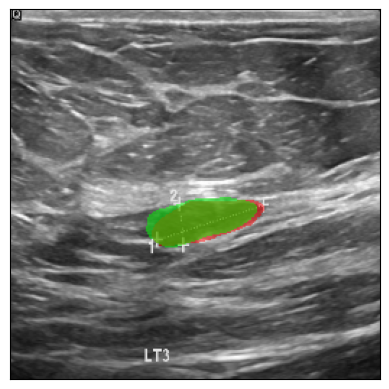

In [ ]:
def visualize_predictions(model, dataset):
    """Visualize model predictions compared to ground truth.
    
    Args:
        model: Trained model
        dataset: Dataset to sample from
        indices: Specific indices to visualize (optional)
        device: Device for inference
    """
    model.eval()
    
    idx = np.random.choice(len(dataset), 1, replace=False)[0]
    
    with torch.inference_mode():
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(model.device)
        mask_gt = sample['mask']
        
        logits = model(image)
        mask_pred = torch.argmax(logits, dim=1).squeeze(0).cpu()

        overlay_mask = draw_masks(image.squeeze(0).cpu(), torch.stack([mask_gt, mask_pred]), alpha=0.5)
        show(overlay_mask)

        yp = (mask_pred == 1).sum().item()
        yg = (mask_gt == 1).sum().item()
        tp = ((mask_pred == 1) & (mask_gt == 1)).sum().item()
        iou = tp / (yp + yg - tp) if (yp + yg - tp) > 0 else 1.0
        print(f"IoU: {iou:.1%}")

visualize_predictions(model, test_dataset)